# Assignment 10
## Gal Dali

### Question 1

#### Monte - Carlo Method

$ \text{Ellipse: } $
$ \frac{x^2}{2^2} + \frac{y^2}{3^2} = 1 $
$ \text{, Circle: } $
$ x^2 + y^2 = 3^2 $

$ \sigma(x, y) = \sigma_0 - y\sqrt{x^2 + y^2} $

$ \sigma_0 = 3 \text{ (in some units)} $

$ N = 10^6  $

$ \vec{E} = \iint_{S} dx~dy~\sigma(x,y) \frac{(x_{0}-x)\hat{x}+(y_{0}-y)\hat{y}+(z_{0}-z)\hat{z}}{((x_{0}-x)^{2}+(y_{0}-y)^{2}+(z_{0}-z)^{2})^{\frac{3}{2}}} $

$ \text{The question says these are three integrals, but I really don't understand why, it looks like only two integrals are in place over x and y } $

$ \text{Goal: Find $\vec{E}$ at the point } (x_0, y_0, z_0) = (\frac{1}{2}, 1, 1) $

$ \vec{E} = \iint_{S} dx~dy~(\sigma_0 - y\sqrt{x^2 + y^2}) \frac{(\frac{1}{2}-x)\hat{x}+(1-y)\hat{y}+(1-z)\hat{z}}{((\frac{1}{2}-x)^{2}+(1-y)^{2}+(1-z)^{2})^{\frac{3}{2}}} $

$ \text {NOTE: The question doesn't mention the coordinates of the circle's center. I assume it is located at (0, 0)} $

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 1_000_000
square_area = 6 * 6
pre_factor = square_area / N
x, y = 6 * np.random.rand(2, N) - 3


def f(x, y):
    sigma_0 = 3
    x0, y0, z0 = 0.5, 1, 1
    z = 0

    # you wrote 3 instead of 9 (3^2) in the notes, and I scratched my head for a long time trying to figure out where is the bug!
    inside_circle = x ** 2 + y ** 2 <= 3 ** 2
    outside_ellipse = (x ** 2) / (2 ** 2) + (y ** 2) / (3 ** 2) > 1

    if inside_circle and outside_ellipse:
        sigma = sigma_0 - y * np.sqrt(x ** 2 + y ** 2)
        denominator = np.power((x0 - x) ** 2 + (y0 - y) ** 2 + (z0 - z) ** 2, 1.5)
        return (sigma * (x0 - x) / denominator,
                sigma * (y0 - y) / denominator,
                sigma * (z0 - z) / denominator)
    else:
        return 0, 0, 0

In [3]:
E = np.array([f(x[i], y[i]) for i in range(N)])
E_x, E_y, E_z = zip(*E)  # split into components

# sum each term (each integral? I think now I understand why you said 3 integrals, but it still feels weird) and multiply by the pre-factor
E_x = np.cumsum(E_x) * pre_factor
E_y = np.cumsum(E_y) * pre_factor
E_z = np.cumsum(E_z) * pre_factor

# combine the results
E = np.array(list(zip(E_x, E_y, E_z)))

In [4]:
# Final converged values (last values in each component)
E_x_final = E_x[-1]
E_y_final = E_y[-1]
E_z_final = E_z[-1]

# More accurate results
E_x_exact = -0.170
E_y_exact = 1.928
E_z_exact = 0.521

print("The electric field at point (x0, y0, z0) = (0.5, 1, 1) is: " +
      str(E_x_final) + "i\u0302 + " + str(E_y_final) + "j\u0302 + " + str(E_z_final) + "k\u0302")

The electric field at point (x0, y0, z0) = (0.5, 1, 1) is: -0.15455521898706054î + 2.559810875014029ĵ + 0.5254864555186228k̂


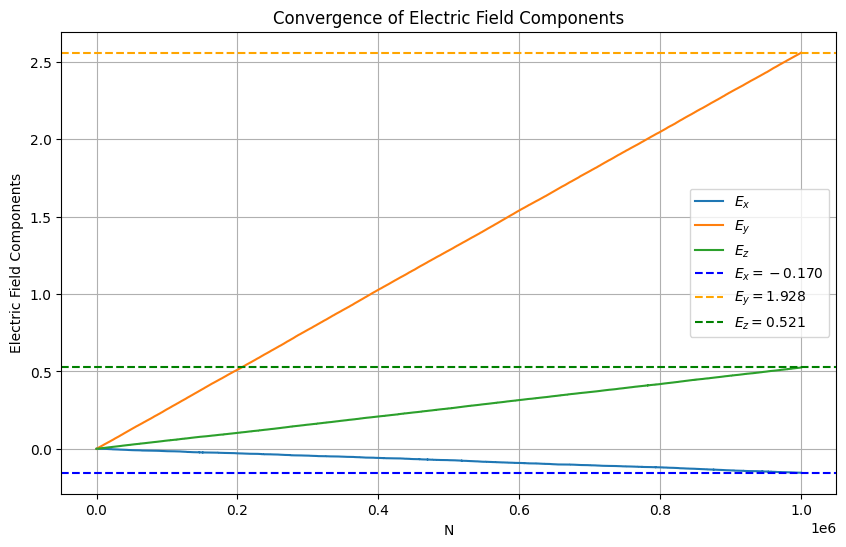

In [5]:
# Plot convergence
plt.figure(figsize=(10, 6))
plt.plot(range(1, N + 1), E_x, label="$E_x$")
plt.plot(range(1, N + 1), E_y, label="$E_y$")
plt.plot(range(1, N + 1), E_z, label="$E_z$")
plt.axhline(E_x[-1], color='blue', linestyle='--', label=f"$E_x = {E_x_exact:.3f}$")
plt.axhline(E_y[-1], color='orange', linestyle='--', label=f"$E_y = {E_y_exact:.3f}$")
plt.axhline(E_z[-1], color='green', linestyle='--', label=f"$E_z = {E_z_exact:.3f}$")
plt.xlabel("N")
plt.ylabel("Electric Field Components")
plt.title("Convergence of Electric Field Components")
plt.legend()
plt.grid()
plt.show()